In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## All imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from typing import List
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import random
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data things

In [2]:
class ImageDataset(Dataset):

    def __init__(self, image_dir, dataset_size=None, transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        if dataset_size is None:
            dataset_size = len(self.image_files)

        self.image_files = random.sample(self.image_files, dataset_size)
        self.transform = transform
        self.image_paths = [os.path.join(self.image_dir, file_name) for file_name in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image) # Calling transform to convert from PIL Image to Tensor Image
        return image

## Setting up the directories and image size

In [3]:
BASE_DIR = '/kaggle/input/flickr8k/Images'
WORKING_DIR = '/kaggle/working'
IMAGE_SIZE = 128

In [4]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Using 3 channels
])

# Example usage with an image
train_dataset = ImageDataset(BASE_DIR, dataset_size = 400, transform=transform)
test_dataset = ImageDataset(BASE_DIR, dataset_size = 180, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, shuffle=True)

## Attention

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads


    def forward(self, x, causal_mask=False):

        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        meantim_embd_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(meantim_embd_shape).transpose(1, 2)
        k = k.view(meantim_embd_shape).transpose(1, 2)
        v = v.view(meantim_embd_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output

## Decoder Related Architechture

In [6]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
      super().__init__()
      self.groupnorm = nn.GroupNorm(32, channels)
      self.attention = SelfAttention(1, channels)


    def forward(self, x):

      # x: (Batch_Size, Features, Height, Width)
      residue = x

      # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
      x = self.groupnorm(x)

      n, c, h, w = x.shape    # n is the batch size, c is the no. of the features, height, weight

      # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
      x = x.view((n, c, h * w))

      # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
      x = x.transpose(-1, -2)

      # Perform self-attention WITHOUT mask on the pixels of the image
      # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
      x = self.attention(x)

      # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
      x = x.transpose(-1, -2)

      # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
      x = x.view((n, c, h, w))

      # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
      x += residue

      # (Batch_Size, Features, Height, Width)
      return x


In [7]:
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_1(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_2(x)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue)

In [8]:
class VAE_Decoder(nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()

        # Define the layers individually
        self.initial_conv = nn.Conv2d(4, 4, kernel_size=1, padding=0)
        self.conv1 = nn.Conv2d(4, 512, kernel_size=3, padding=1)
        self.res_block1 = VAE_ResidualBlock(512, 512).to(device)
        self.attention_block = VAE_AttentionBlock(512).to(device)
        self.res_block2 = VAE_ResidualBlock(512, 512).to(device)
        self.res_block3 = VAE_ResidualBlock(512, 512).to(device)
        self.res_block4 = VAE_ResidualBlock(512, 512).to(device)
        self.res_block5 = VAE_ResidualBlock(512, 512).to(device)

        self.upsample1 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.res_block6 = VAE_ResidualBlock(512, 512).to(device)
        self.res_block7 = VAE_ResidualBlock(512, 512).to(device)
        self.res_block8 = VAE_ResidualBlock(512, 512).to(device)

        self.upsample2 = nn.Upsample(scale_factor=2)
        self.conv3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.res_block9 = VAE_ResidualBlock(512, 256).to(device)

        self.res_block10 = VAE_ResidualBlock(256, 256).to(device)
        self.res_block11 = VAE_ResidualBlock(256, 256).to(device)

        self.upsample3 = nn.Upsample(scale_factor=2)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.res_block12 = VAE_ResidualBlock(256, 128).to(device)
        self.res_block13 = VAE_ResidualBlock(128, 128).to(device)
        self.res_block14 = VAE_ResidualBlock(128, 128).to(device)

        self.group_norm = nn.GroupNorm(32, 128)
        self.silu = nn.SiLU()
        self.output_conv = nn.Conv2d(128, 3, kernel_size=3, padding=1)


    def forward(self, x):
        # Scaling added by the Encoder is removed here
        x /= 0.18215

        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = self.initial_conv(x)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.conv1(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.res_block1(x)
         # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.attention_block(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.res_block2(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.res_block3(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.res_block4(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.res_block5(x)

        # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.upsample1(x)
        # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.conv2(x)
         # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.res_block6(x)
         # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.res_block7(x)
         # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.res_block8(x)

        # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
        x = self.upsample2(x)
        # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 512, Height / 2, Width / 2)
        x = self.conv3(x)
        # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
        x = self.res_block9(x)
         # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
        x = self.res_block10(x)
         # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
        x = self.res_block11(x)
        # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
        x = self.upsample3(x)
        # (Batch_Size, 256, Height, Width) -> (Batch_Size, 256, Height, Width)
        x = self.conv4(x)
        # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.res_block12(x)
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.res_block13(x)
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.res_block14(x)
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.group_norm(x)

        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.silu(x)
        
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
        x = self.output_conv(x)



#         # # (Batch_Size, 128, Height, Width) -> (Batch_Size, 6, Height, Width)
#         x = self.output_conv(x)

        # (Batch_Size, 6, Height , Width ) -> two tensors of shape (Batch_Size, 6, Height , Width )
#         mean, log_variance = torch.chunk(x, 2, dim=1)

#          # Clamp the log variance
#         log_variance = torch.clamp(log_variance, -30, 20)
#         # (Batch_Size, 3, Height , Width )
#         x = mean  # Set `x` to the mean for the final reconstruction

#         return {"x": x, "mu": mean, "log_var": log_variance}

        x = torch.tanh(x) 

        return x

## Encoder

In [9]:
class VAE_Encoder(nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()

        # Initial convolution and residual layers
        self.initial_conv = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.residual_block1 = VAE_ResidualBlock(128, 128).to(device)
        self.residual_block2 = VAE_ResidualBlock(128, 128).to(device)

        # Downsampling and more residual blocks
        self.downsample1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0)
        self.residual_block3 = VAE_ResidualBlock(128, 256).to(device)
        self.residual_block4 = VAE_ResidualBlock(256, 256).to(device)

        self.downsample2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0)
        self.residual_block5 = VAE_ResidualBlock(256, 512).to(device)
        self.residual_block6 = VAE_ResidualBlock(512, 512).to(device)

        self.downsample3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0)
        self.residual_block7 = VAE_ResidualBlock(512, 512).to(device)
        self.residual_block8 = VAE_ResidualBlock(512, 512).to(device)
        self.residual_block9 = VAE_ResidualBlock(512, 512).to(device)

        # Attention and normalization
        self.attention = VAE_AttentionBlock(512).to(device)
        self.norm = nn.GroupNorm(32, 512)
        self.activation = nn.SiLU()

        # Final convolutional layers
        # Because the padding=1, it means the width and height will increase by 2
        # Out_Height = In_Height + Padding_Top + Padding_Bottom
        # Out_Width = In_Width + Padding_Left + Padding_Right
        # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
        # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8).
        self.final_conv3x3 = nn.Conv2d(512, 8, kernel_size=3, padding=1)
        # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
        self.final_conv1x1 = nn.Conv2d(8, 8, kernel_size=1, padding=0)

    def forward(self, x, noise=0):
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.initial_conv(x)
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.residual_block1(x)
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
        x = self.residual_block2(x)

        # Downsample and apply padding
        x = F.pad(x, (0, 1, 0, 1))  # Pad on the right and bottom
        # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
        x = self.downsample1(x)
        # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
        x = self.residual_block3(x)
         # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
        x = self.residual_block4(x)

        x = F.pad(x, (0, 1, 0, 1))
        # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
        x = self.downsample2(x)
        # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.residual_block5(x)
        # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
        x = self.residual_block6(x)

        x = F.pad(x, (0, 1, 0, 1))
        # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.downsample3(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.residual_block7(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.residual_block8(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.residual_block9(x)

        # Apply attention, normalization, and activation
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.attention(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.norm(x)
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
        x = self.activation(x)

        # Final convolutions
        # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8).
        x = self.final_conv3x3(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
        x = self.final_conv1x1(x)

        # Split into mean and log variance
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)      # we are having the log_variance instead of the variance

        # Clamp the log variance
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt()

        # Apply noise for reparameterization trick
        # Transform N(0, 1) -> N(mean, stdev)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = mean + stdev * noise

        # Scale the output
        x *= 0.18215

        return x,  mean, log_variance

In [10]:
from torchvision import models
import torch.nn.functional as F

# Initializing a pre-trained VGG model for perceptual loss
vgg = models.vgg16(pretrained=True).features.eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

def vae_gaussian_kl_loss(mu, logvar):
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        return KLD.mean()

def perceptual_loss(x_reconstructed, x, vgg):
    # Extracting features from VGG layers for perceptual loss
    def vgg_features(x):
        # Passing input through VGG layers up to the relu3_3 layer
        return vgg[:16](x)
    
    x_recon_features = vgg_features(x_reconstructed)
    x_features = vgg_features(x)
    return F.mse_loss(x_recon_features, x_features)

def reconstruction_loss(x_reconstructed, x):
    # here using BCE loss for more stable color reproduction if pixel values are in [0, 1]
    x = (x + 1) / 2
    x_reconstructed = (x_reconstructed + 1) / 2
    if x.min() < 0 or x.max() > 1:
        print(x)
        print(f"Normalizeing {x.min().item()} and {x.max().item()}")

    if x_reconstructed.min() < 0 or x_reconstructed.max() > 1:
        print(f"Normalizeing {x_reconstructed.min().item()} and {x_reconstructed.max().item()}")

    
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='mean') / x.size(0)
    return recon_loss

def vae_loss(y_pred, y_true, epoch):
    mu, logvar, recon_x = y_pred
    recon_loss = reconstruction_loss(recon_x, y_true)
    
    # applying perceptual loss to encourage color and feature realism
    percept_loss = perceptual_loss(recon_x, y_true, vgg)
    
    # Combining perceptual and reconstruction loss
    combined_recon_loss = recon_loss + 0.1 * percept_loss
    
    # KL Divergence loss with dynamic weighting
    kld_loss = vae_gaussian_kl_loss(mu, logvar)
    kl_weight = min(1.0, epoch / 20)  # Gradually increase KL weight over first 20 epochs
    
    # final weighted loss
    return 500 * combined_recon_loss + kld_loss * kl_weight



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 219MB/s] 


In [11]:
class VanillaVAE(nn.Module):

    def __init__(self, in_channels: int, latent_dim: int, hidden_dims: List[int] = None, num_epochs: int = 25):
        """
        Initialize the VAE model with encoder and decoder architectures.
        """
        super(VanillaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.in_channels = in_channels
        self.encoder = VAE_Encoder().to(device)
        self.decoder = VAE_Decoder().to(device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.num_epochs = num_epochs
    
    def getEncoder(self, nk, x):
        nx, _, _ = self.encoder(x)
        return nx
        
    def forward(self, x):
        # passing the input through the encoder to get the latent vector
        z, z_mean, z_log_var = self.encoder(x)
        # passing the latent vector through the decoder to get the reconstructed image
        reconstruction = self.decoder(z)
        # returning the mean, log variance and the reconstructed image
        return z_mean, z_log_var, reconstruction

    def reparameterize(self, mu: Tensor, lv: Tensor) -> Tensor:  # lv is log_variance
        # print(f"mu-", mu.size())
        # print("lv-", lv.size())
        # print("eps-", epsilon.size())
        epsilon = torch.randn(mu.shape, device=mu.device)
        sigma = torch.exp(0.5 * lv)  # Standard deviation
        z = mu + sigma * epsilon
        return z


    def train(self, train_loader, start_epoch=0) -> List[Tensor]:
        self.to(device)

        for epoch in range(start_epoch, self.num_epochs):  
            epoch_loss = 0
            for batch in train_loader:
                batch = batch.to(device)
                pred = self(batch)
                loss = vae_loss(pred, batch, epoch)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()  # Accumulating loss for average calculation
                print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

                # Saving model and optimizer state at epoch 40 and every 49 epochs
                if (epoch + 1) == 40 or (epoch + 1) % 50 == 0:
                    torch.save({
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'epoch': epoch + 1,
                    }, f"vae_model_epoch_{epoch + 1}.pth")
                    print(f"Model and optimizer state saved at epoch {epoch + 1}")
                    
                if loss == 0:
                    print("stopped")
                    break

            print(f"Epoch: {epoch + 1}, Avg_Loss: {epoch_loss / len(train_loader)}")
            print()

        return loss




In [ ]:
"""
    Here is the elbo loss calculated as described in the Paper[https://arxiv.org/abs/2003.05991] we can replace the construction loss by the elbo loss to train the vae but as we observed straight forward 
    construction loss is giving much more better result than the complex elbo loss 
"""



def elbo(self, latent_dist, output_dist, x, epoch):    ## here x is the batch of images
    # Unpacking mean and log variance for latent and output distributions
    z, mu_z, log_var_z = latent_dist['x'], latent_dist['mu'], latent_dist['log_var']
    x, mu_x, log_var_x = output_dist['x'], output_dist['mu'], output_dist['log_var']
    
    half_ln2pi = (1/2) * torch.log(torch.tensor(2.0) * torch.pi)
    
    logqz = (-1) * half_ln2pi - (1/2) * log_var_z - ((z - mu_z)**2)/(2 * torch.exp(log_var_z))
    logpz = (-1) * half_ln2pi - ((z)**2)/(2)
    
    logpx_z = (-1) * half_ln2pi - (1/2) * log_var_x - ((x - mu_x)**2)/(2 * torch.exp(log_var_x))   ## log(p(x|z))
    
    ## putting all together
# Computing the expected values
    # Average log likelihood of reconstruction
    logpx_z_mean = torch.mean(logpx_z)
    # Average KL divergence
    kl_divergence = torch.mean(logqz - logpz)

    # ELBO: reconstruction term - KL divergence
    elbo = logpx_z_mean - kl_divergence

    return elbo



In [12]:
vae = VanillaVAE(in_channels=3, latent_dim=128, num_epochs=600).to(device)

In [15]:
# vae.load_state_dict(torch.load("/kaggle/input/load-vae499epoch/vae_modelRGBLoss_499.pth"))
# vae.to(device) 

In [13]:
# Loading the checkpoint
checkpoint = torch.load('/kaggle/input/clipeoch600/vae_model_epoch_600.pth')  

# Loading... 
vae.load_state_dict(checkpoint['model_state_dict'])
vae.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


start_epoch = checkpoint['epoch'] + 1  

# you can continue training
# vae.train(train_loader, start_epoch=start_epoch)

/tmp/ipykernel_30/1412445919.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/clipeoch600/vae_model_epoch_600.pth')


In [ ]:
vae.train(train_loader)

## The transform will convert the image which is in range 0 to 1 the -1 to 1 range thats what model required

torch.Size([3, 525, 800])
tensor([[[-0.6941, -0.7176, -0.6706,  ..., -0.9765, -0.9686, -0.9529],
         [-0.7882, -0.7882, -0.7098,  ..., -0.9686, -0.9608, -0.9451],
         [-0.7882, -0.7725, -0.7333,  ..., -0.9608, -0.9529, -0.9451],
         ...,
         [-0.9137, -0.9216, -0.9373,  ..., -0.9529, -0.9451, -0.9451],
         [-0.9059, -0.9216, -0.9373,  ..., -0.9529, -0.9529, -0.9451],
         [-0.8980, -0.9137, -0.9373,  ..., -0.9529, -0.9529, -0.9529]],

        [[-0.6941, -0.7176, -0.6706,  ..., -0.9765, -0.9686, -0.9529],
         [-0.7882, -0.7882, -0.7098,  ..., -0.9686, -0.9608, -0.9451],
         [-0.7882, -0.7725, -0.7333,  ..., -0.9608, -0.9529, -0.9451],
         ...,
         [-0.9137, -0.9216, -0.9373,  ..., -0.9529, -0.9451, -0.9451],
         [-0.9059, -0.9216, -0.9373,  ..., -0.9529, -0.9529, -0.9451],
         [-0.8980, -0.9137, -0.9373,  ..., -0.9529, -0.9529, -0.9529]],

        [[-0.6941, -0.7176, -0.6706,  ..., -0.9765, -0.9686, -0.9529],
         [-0.7882, 

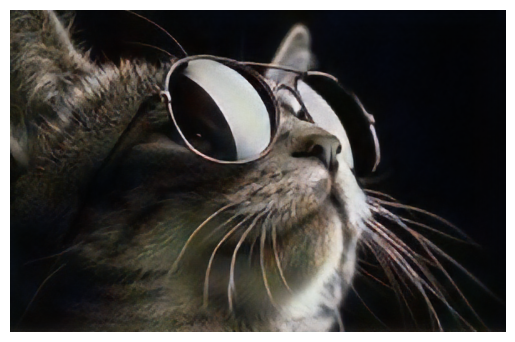

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Open the image
image = Image.open('/kaggle/input/test-images/cat.jpg')

# Define a transform to convert the image to a tensor
transform = transforms.Compose([
    transforms.Resize((525, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Using 3 channels
])


# Apply the transform to the image
image_tensor = transform(image).to(device)
print(image_tensor.shape)
print(image_tensor)

# Pass through VAE and get the reconstructed output
_, _, reconstructed = vae(image_tensor.unsqueeze(0))

# Move reconstructed tensor to CPU and convert to numpy
reconstructed_image = reconstructed.squeeze().cpu().detach().numpy()
print(reconstructed_image.shape)
# Convert the tensor to a format compatible with OpenCV
# Assuming the output is in CHW format, convert it to HWC
reconstructed_image = reconstructed_image.transpose(1, 2, 0)  
print(reconstructed_image)

# Ensure values are in [0, 1] range for plt.imshow
# If the output is in range [-1, 1], normalize to [0, 1]
reconstructed_image = (reconstructed_image + 1) / 2  # Scale to [0, 1]
reconstructed_image = np.clip(reconstructed_image, 0, 1)  # Clip to ensure no values are out of range

# Display the reconstructed image using matplotlib
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()


In [ ]:
# # Define the reverse transform to convert back to original range and format
# reverse_transform = transforms.Compose([
#     transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),  # Reverse normalization
#     transforms.ToPILImage()  # Convert back to PIL image format
# ])

# # Apply reverse transform
# print(reconstructed.shape)
# reconstructed_image_pil = reverse_transform(reconstructed.squeeze().cpu())

# # Display using matplotlib
# plt.imshow(reconstructed_image_pil)
# plt.axis('off')
# plt.show()




# OUTPUT IMAGE

torch.Size([1, 3, 520, 800])
torch.Size([1, 3, 520, 800])


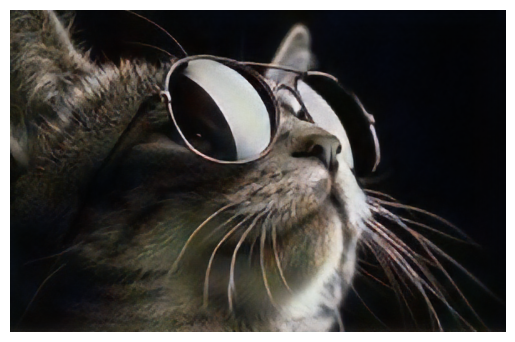

In [20]:
# Define the reverse transform to convert back to original range and format
reverse_transform = transforms.Compose([
    transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),  # Reverse normalization
#     transforms.ToPILImage()  # Convert back to PIL image format
])

# Apply reverse transform
print(reconstructed.shape)
reconstructed_image_pil = reverse_transform(reconstructed.cpu())
print(reconstructed_image_pil.shape)
# Display using matplotlib
reconstructed_image_pil = reconstructed_image_pil.squeeze(0)
reconstructed_image_pil = reconstructed_image_pil.permute(1, 2, 0)
reconstructed_image_pil= reconstructed_image_pil.detach().numpy()

plt.imshow(reconstructed_image_pil)
plt.axis('off')
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# from torchvision import transforms

# # Open the image
# image = Image.open('/kaggle/input/test-images/cat.jpg')

# # Define a transform to convert the image to a tensor
# transform = transforms.ToTensor()

# # Apply the transform to the image
# image_tensor = transform(image).to(device)
# print(image_tensor.shape)
# print(image_tensor)

# nx = vae.getEncoder(image_tensor.unsqueeze(0))
# print(nx.shape)
# print(nx)


# #  `encoder_output` is the tensor [1, 4, 65, 100]


# # Remove the batch dimension (1), resulting in [4, 65, 100]
# output_images = nx.squeeze(0)

# # Plot each channel as a separate image
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# for i in range(4):
#     axes[i].imshow(output_images[i].detach().cpu().numpy(), cmap='gray')
#     axes[i].set_title(f'Channel {i + 1}')
#     axes[i].axis('off')
# plt.show()


torch.Size([3, 520, 800])
tensor([[[-0.6941, -0.7176, -0.6706,  ..., -0.9765, -0.9686, -0.9529],
         [-0.7882, -0.7882, -0.7098,  ..., -0.9686, -0.9608, -0.9451],
         [-0.7882, -0.7725, -0.7333,  ..., -0.9608, -0.9529, -0.9451],
         ...,
         [-0.9137, -0.9216, -0.9373,  ..., -0.9529, -0.9451, -0.9451],
         [-0.9059, -0.9216, -0.9373,  ..., -0.9529, -0.9529, -0.9451],
         [-0.8980, -0.9137, -0.9373,  ..., -0.9529, -0.9529, -0.9529]],

        [[-0.6941, -0.7176, -0.6706,  ..., -0.9765, -0.9686, -0.9529],
         [-0.7882, -0.7882, -0.7098,  ..., -0.9686, -0.9608, -0.9451],
         [-0.7882, -0.7725, -0.7333,  ..., -0.9608, -0.9529, -0.9451],
         ...,
         [-0.9137, -0.9216, -0.9373,  ..., -0.9529, -0.9451, -0.9451],
         [-0.9059, -0.9216, -0.9373,  ..., -0.9529, -0.9529, -0.9451],
         [-0.8980, -0.9137, -0.9373,  ..., -0.9529, -0.9529, -0.9529]],

        [[-0.6941, -0.7176, -0.6706,  ..., -0.9765, -0.9686, -0.9529],
         [-0.7882, 

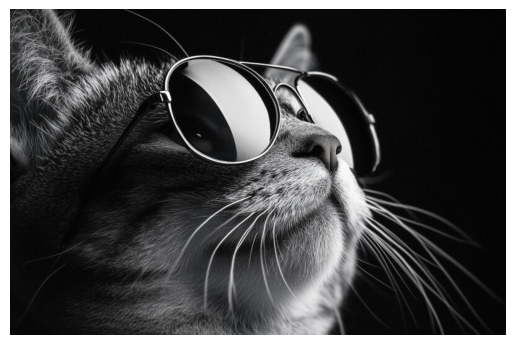

Mean Absolute Error (MAE): 0.10313451290130615
Mean Squared Error (MSE): 0.03389722853899002


In [21]:
from PIL import Image
transform =  transforms.Compose([
    transforms.Resize((520, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Using 3 channels
])


image = Image.open('/kaggle/input/test-images/cat.jpg')
image_tensor = transform(image).to(device)
print(image_tensor.shape)
print(image_tensor)

plt.imshow(image)
plt.axis('off')
plt.show()

# Calculate the Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = torch.mean(torch.abs(image_tensor - reconstructed))
print(f"Mean Absolute Error (MAE): {mae.item()}")

mse = torch.mean((image_tensor - reconstructed) ** 2)
print(f"Mean Squared Error (MSE): {mse.item()}")


# INPUT IMAGE

In [ ]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

# Example: ensure `reconstructed_image` is in the proper format
reconstructed_image = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

# Convert to PIL image
reconstructed_image_pil = Image.fromarray(reconstructed_image.squeeze())  # Remove any extra dimensions if necessary

# Define the transform
transform = transforms.Compose([
    transforms.Resize((520, 800)),
    transforms.ToTensor()
])

# Load and transform both images
image1 = transform(Image.open('/kaggle/input/test-images/cat.jpg')).to(device)
image2 = transform(reconstructed_image_pil).to(device)


# Calculate the Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = torch.mean(torch.abs(image1 - image2))
print(f"Mean Absolute Error (MAE): {mae.item()}")

mse = torch.mean((image1 - image2) ** 2)
print(f"Mean Squared Error (MSE): {mse.item()}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Open the image
image = Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')

# Define a transform to convert the image to a tensor
transform = transforms.ToTensor()

# Apply the transform to the image
image_tensor = transform(image).to(device)
print(image_tensor.shape)
print(image_tensor)

# Pass through VAE and get the reconstructed output
_, _, reconstructed = vae(image_tensor.unsqueeze(0))

# Move reconstructed tensor to CPU and convert to numpy
reconstructed_image = reconstructed.squeeze().cpu().detach().numpy()

# Convert the tensor to a format compatible with OpenCV
# Assuming the output is in CHW format, convert it to HWC
reconstructed_image = reconstructed_image.transpose(1, 2, 0)  
print(reconstructed_image)

# Ensure values are in [0, 1] range for plt.imshow
# If the output is in range [-1, 1], normalize to [0, 1]
reconstructed_image = (reconstructed_image + 1) / 2  # Scale to [0, 1]
reconstructed_image = np.clip(reconstructed_image, 0, 1)  # Clip to ensure no values are out of range

# Display the reconstructed image using matplotlib
plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()


In [ ]:
from PIL import Image
transform = transforms.ToTensor()
image = Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')
image_tensor = transform(image).to(device)
print(image_tensor.shape)
print(image_tensor)

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Save model
torch.save(vae.state_dict(), "vae_modelRGBLoss_499.pth")

In [ ]:
import torch
model = VanillaVAE(in_channels=3, latent_dim=128, num_epochs=40).to(device)

# the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters: {num_params}')


In [ ]:
## CLEAR THE GPU MEMORY
import torch

# Clear cache
torch.cuda.empty_cache()

# clear out all cached tensors to release memory
torch.cuda.memory_summary(device=None, abbreviated=False)


In [ ]:
from IPython.display import FileLink

# Create a downloadable link for the zip file
FileLink('vae_model_epoch_600.pth')


In [ ]:
import os

# List files in the output directory
output_directory = '/kaggle/working/'
files = os.listdir(output_directory)
print(files)


In [ ]:
from google.colab import files  # or just use 'files' if not in Colab

files.download('/kaggle/working/vae_model_epoch_150.pth')


In [ ]:
kaggle  download -d kaggle/working/vae_model.pth
